As a baseline method, I've implemented Criminsi's method for single view metrology, using distances between parallel planes. The basic procedure is as follows:

- Find vanishing points of three pairs of parallel lines from the scene, use this to establish a coordinate frame and estimate camera focal length. This gives us both the intrinsics and extrinsic rotation matrix, if we assume prior knowledge of the camera center
- Next, we select a point on the ground plane to be the world origin, and use another point, either on the ground plane or on a parallel plane, at a known distance from this origin to establish the scene scale, which nets us the extrinsic translation matrix
- We can now find the distances between either arbitrary ground plane points, or corresponding points on the ground plane and a parallel plane

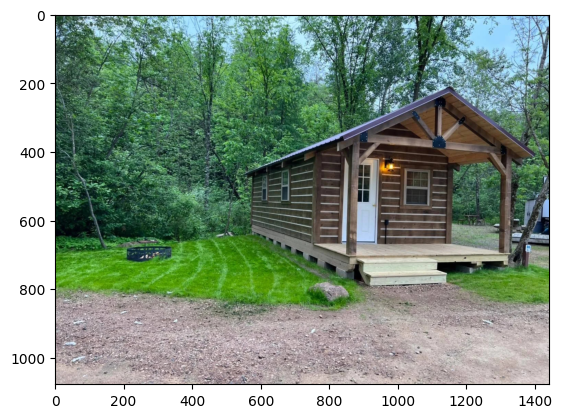

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

%matplotlib inline

img = cv.imread("images/test7.jpg")

_ = plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [2]:
get_color = lambda i: (127 * (i % 3), 127 * ((i + 1) % 3), 127 * ((i + 2) % 3))

In [249]:
# each xi, yi, zi is a line (two points)
# (x1, x2) || (x3, x4), (y1, y2) || (y3, y4), (z1, z2) || (z3, z4)
%matplotlib Qt

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
pts = plt.ginput(12, 500)

parallel_lines = np.zeros((3, 2, 2, 2))

for i in range(6):
	dim = i // 2
	line = i % 2

	parallel_lines[dim][line][0] = np.array(pts[i * 2])
	parallel_lines[dim][line][1] = np.array(pts[i * 2 + 1])

np.save("criminsi_data/test7_parallel_lines.npy", parallel_lines)

In [3]:
parallel_lines = np.load("criminsi_data/test7_parallel_lines.npy")
axes = parallel_lines[:, 0, :]

axes

array([[[ 857.87475345,  704.74654832],
        [1327.03977646,  697.90894149]],

       [[ 847.88132807,  697.90894149],
        [ 855.77087442,  442.28763971]],

       [[ 858.40072321,  705.27251808],
        [ 572.7991453 ,  612.17587114]]])

In [266]:
# pick an origin
%matplotlib Qt

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
origin = np.array(plt.ginput(1)[0])
np.save("criminsi_data/test7_origin.npy", origin)

In [4]:
origin = np.load("criminsi_data/test7_origin.npy")

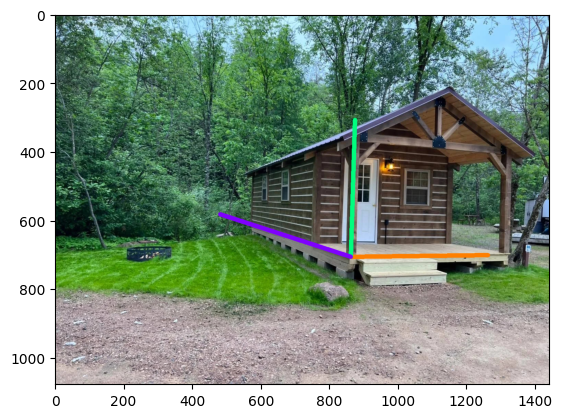

In [5]:
%matplotlib inline

axis_guys = img.copy()

length = 400

for i, axis in enumerate(axes):
	axis_dir = axis[1] - axis[0]
	axis_dir /= np.linalg.norm(axis_dir)

	pt_a = np.rint(origin).astype(np.uint64)
	pt_b = np.rint(origin + length * axis_dir).astype(np.uint64)

	cv.line(axis_guys, pt_a, pt_b, get_color(i), 12)

plt.imshow(cv.cvtColor(axis_guys, cv.COLOR_BGR2RGB))

Now that we've established the axes, we find their vanishing points to recover the extrinsic rotation matrix & estimate the camera focal length

We can simply intersect our paired parallel lines to find these vanishing points

In [6]:
def intersect_lines(l1: np.array, l2: np.array):
	"""
	finds the intersection point of two lines in two-point form, lifted from https://math.stackexchange.com/a/3176648
	"""

	n = l1[1] - l1[0]
	m = l2[0] - l2[1]
	p = l2[0] - l1[0]

	D = n[0] * m[1] - n[1] * m[0]

	# singularity (maybe should be a range for dodging poorly conditioned cases)
	assert D != 0

	Qx = m[1] * p[0] - m[0] * p[1]

	t = Qx / D

	return l1[0] + t * n

In [45]:
l1 = parallel_lines[0][0]
l2 = parallel_lines[0][1]

vp = intersect_lines(l1, l2)

h, w, _ = img.shape

img_big = 255 * np.ones((4000, 5000, 3), dtype=np.uint16)

top_left = np.array([1000, 2500])

img_big[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w] = img

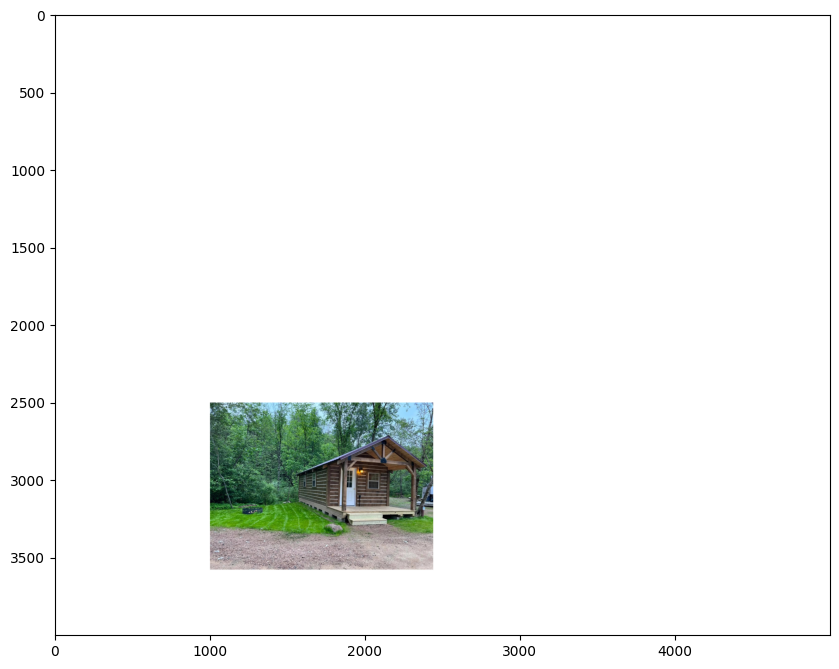

In [46]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(img_big, cv.COLOR_BGR2RGB))

In [49]:
vps = [vp] + [None] * (len(parallel_lines) - 1)

for i, lines in enumerate(parallel_lines[1:]):
	l1, l2 = lines[0], lines[1]
	vp = intersect_lines(l1, l2)
	vps[i + 1] = vp

In [50]:
vps

[array([3875.57477918,  660.76661521]),
 array([  3673.43666645, -90850.08402188]),
 array([298.40608215, 522.73282845])]

In [60]:
vps_guy = img_big.copy()

h, w, _ = img_big.shape

for axis in [0, 2]:
	vp_t = (vps[axis] + top_left).astype(np.uint64)

	for i, l in enumerate(parallel_lines[axis]):
		dir = l[1] - l[0]
		dir /= np.linalg.norm(dir)

		t = 5000

		b = (l[0] + top_left + t * dir).astype(np.uint64)
		while b[0] < 0 or b[0] >= w or b[1] < 0 or b[1] >= h:
			t *= 15/16
			b = (l[0] + top_left + t * dir).astype(np.uint64)

		a = (l[0] + top_left).astype(np.uint64)

		cv.line(vps_guy, a, b, get_color(i), 3)

	cv.circle(vps_guy, vp_t, 5, 5)

%matplotlib Qt
plt.imshow(cv.cvtColor(vps_guy, cv.COLOR_BGR2RGB))